## Useful codes and functions for Tutorial 3

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from itertools import product
from statsmodels.tsa.stattools import adfuller

In [5]:
df = pd.read_csv('dataset1-2.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Value
0,2023-09-12,0.319383
1,2023-09-13,0.373839
2,2023-09-14,0.447583
3,2023-09-15,-0.252889
4,2023-09-16,-0.468198


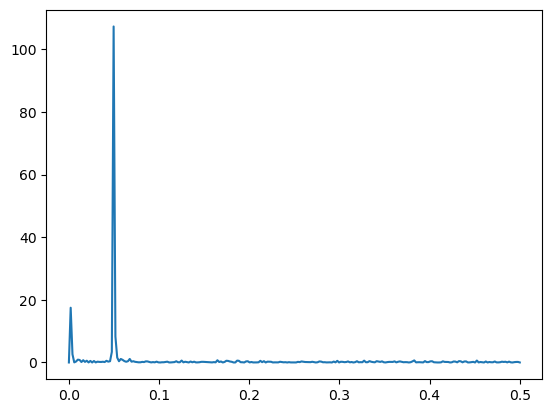

In [6]:
frequencies, power_spectrum = signal.periodogram(df['Value'], fs=1)
plt.plot(frequencies, power_spectrum)

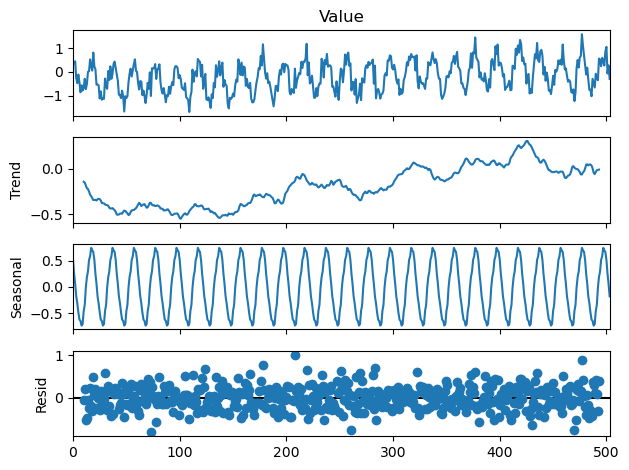

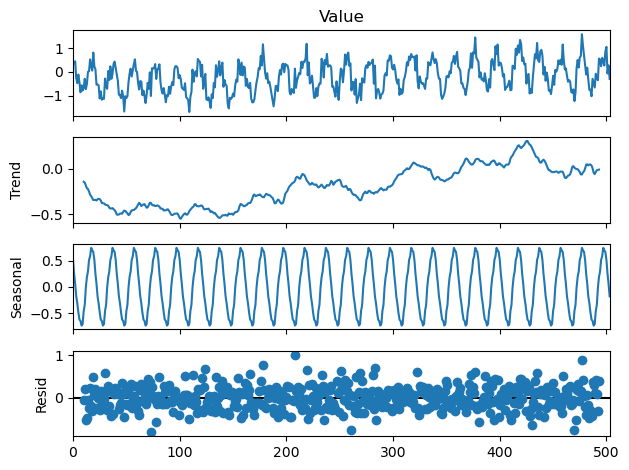

In [7]:
# critical value is over 0.05 to find optimal number of period is 1/0.05=20
period = 20 # change as needed

result_season_trend = seasonal_decompose(df['Value'], model='additive', period=period)
result_season_trend.plot()

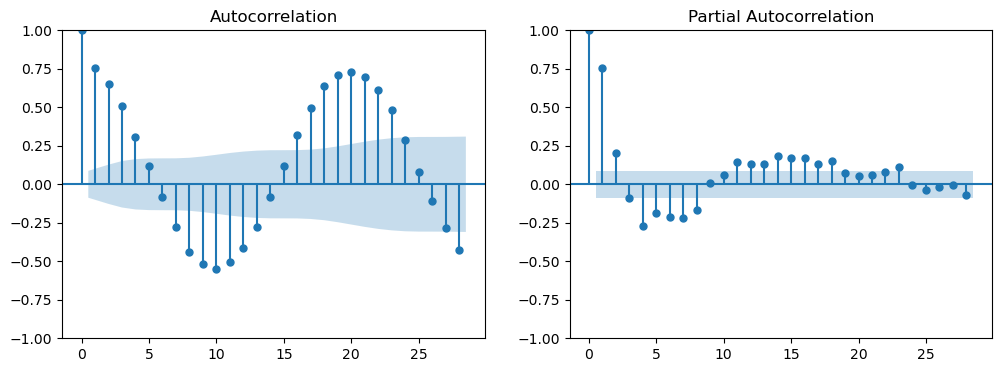

/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.12/site-package

Optimal ARMA(p,q) order: (4, 4)
Best AIC: 239.13679279250735


/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  504
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -109.568
Date:                Tue, 28 Jan 2025   AIC                            239.137
Time:                        13:29:33   BIC                            281.363
Sample:                             0   HQIC                           255.700
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1417      0.095     -1.497      0.134      -0.327       0.044
ar.L1          1.8863      2.526      0.747      0.455      -3.065       6.838
ar.L2          0.0143      7.291      0.002      0.9

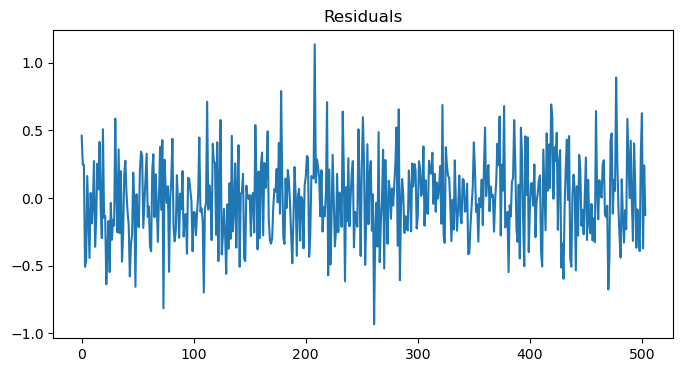

ADF Statistic: -22.865735815272465
p-value: 0.0
Critical Values:
   1%: -3.4434175660489905
   5%: -2.8673031724657454
   10%: -2.5698395516760275


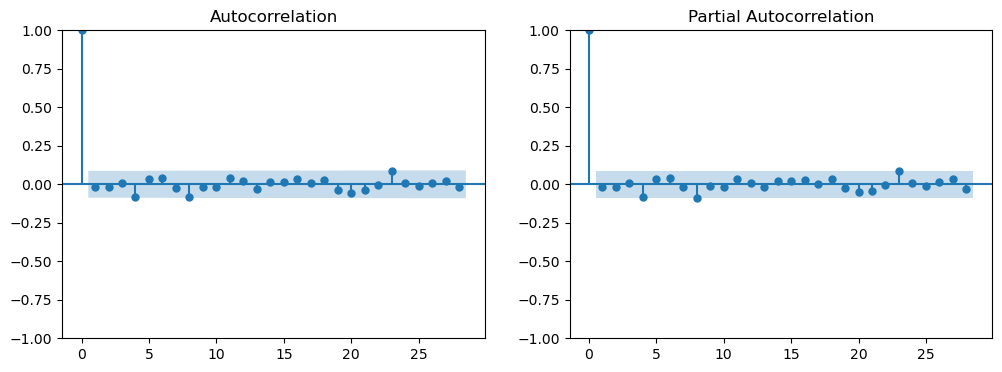

In [8]:


# ACF & PACF Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['Value'], ax=axes[0])
plot_pacf(df['Value'], ax=axes[1])
plt.show()

# Select optimal (p,q) using AIC
p_values = range(0, 5)  # Adjust range as needed
q_values = range(0, 5)
best_aic = np.inf
best_order = None
best_model = None

for p, q in product(p_values, q_values):
    try:
        model = ARIMA(df['Value'], order=(p, 0, q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, q)
            best_model = results
    except:
        continue

print(f'Optimal ARMA(p,q) order: {best_order}')
print(f'Best AIC: {best_aic}')

# Fit Optimal Model
final_model = ARIMA(df['Value'], order=(best_order[0], 0, best_order[1]))
final_results = final_model.fit()
print(final_results.summary())

# Extract Estimated Coefficients & Residual Variance
print("Estimated Coefficients:\n", final_results.params)
print("Residual Variance:", np.var(final_results.resid))

# Residual Analysis (
plt.figure(figsize=(8, 4))
plt.plot(final_results.resid)
plt.title('Residuals')
plt.show()

# Perform ADF test on residuals (p-value = 0 so stationnary) 
adf_result = adfuller(final_results.resid)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


# Check Residuals for White Noise
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(final_results.resid, ax=axes[0])
plot_pacf(final_results.resid, ax=axes[1])
plt.show()

In [9]:
# Step 1: Seasonality-Based Prediction
period = 20  # Adjust based on previous decomposition
result_season_trend = seasonal_decompose(df['Value'], model='additive', period=period)

# Extract seasonal component
seasonal_component = result_season_trend.seasonal

# Find the seasonality value for 23/02 of previous years
forecast_date = datetime(2025, 2, 23)
try:
    seasonal_value = seasonal_component.loc[forecast_date]
except KeyError:
    seasonal_value = seasonal_component.iloc[-1]  # Use the last available seasonal value if missing

# Determine sign of Value (we think pt will be negative on 23rd of feb)
seasonality_prediction = "Positive" if seasonal_value > 0 else "Negative"
print(f"Seasonality-Based Prediction for 23/02/2025: {seasonality_prediction}")

# Step 2: ARMA(4,4) Forecast
optimal_order = (4, 0, 4)  # ARMA(4,4) is equivalent to ARIMA(4,0,4)
final_model = ARIMA(df['Value'], order=optimal_order)
final_results = final_model.fit()

# Forecast 1-step ahead
forecast_steps = (forecast_date - df.index[-1]).days  # Days ahead for forecasting
forecast = final_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean.iloc[-1]
forecast_std = forecast.se_mean.iloc[-1]

print(f"Forecasted Value for 23/02/2025: {forecast_mean:.4f}")
print(f"Forecast Standard Error: {forecast_std:.4f}")




Seasonality-Based Prediction for 23/02/2025: Negative


/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'int'

In [96]:
#expected payoff 
# Given values
forecast_mean = -0.1416  # ARMA forecasted value
forecast_std = 0.4240    # ARMA forecast standard error
last_observed_price = df['Value'].iloc[-1]  # Last observed log-price

# Bet thresholds
lower_bound = -0.49
upper_bound = -0.29

# Compute probabilities
p_up = 1 - norm.cdf((last_observed_price - forecast_mean) / forecast_std)
p_down = norm.cdf((last_observed_price - forecast_mean) / forecast_std)
p_range = norm.cdf((upper_bound - forecast_mean) / forecast_std) - norm.cdf((lower_bound - forecast_mean) / forecast_std)
p_out_range = 1 - p_range

# Bet Prices
bet_prices = {"Up": 0.16, "Down": 0.84, "Range": 0.77, "Out of Range": 0.23}

# Expected Payoffs
expected_payoffs = {
    "Up": p_up * 1 - bet_prices["Up"],
    "Down": p_down * 1 - bet_prices["Down"],
    "Range": p_range * 1 - bet_prices["Range"],
    "Out of Range": p_out_range * 1 - bet_prices["Out of Range"]
}

# Select best two bets
sorted_bets = sorted(expected_payoffs.items(), key=lambda x: x[1], reverse=True)

# Display results
for bet, payoff in sorted_bets:
    print(f"{bet} Bet - Expected Payoff: {payoff:.4f}")

# Best two bets
best_bets = sorted_bets[:2]
print(f"\nBest Two Bets: {best_bets[0][0]} and {best_bets[1][0]}")

Out of Range Bet - Expected Payoff: 0.6125
Up Bet - Expected Payoff: 0.4778
Down Bet - Expected Payoff: -0.4778
Range Bet - Expected Payoff: -0.6125

Best Two Bets: Out of Range and Up


In [ ]:
# bought out of range and down bet payoff = 0.1347 
(buying down bet was a mistake, tried to sell it, no buyer) 